In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy

from collections import defaultdict
from copy import deepcopy
from tqdm.notebook import tqdm

rng = np.random.default_rng(42)

We want to ensure that we have a confidence interval for the Self-Normalised IPS estimator that has the correct coverage.

We wish to do this by taking the _Effective Sample Size (ESS)_ into account.

We can consider multiple estimators for the ESS.
First, we consider two general estimators taken from ["Effective sample size for importance sampling based on discrepancy measures"](https://www.sciencedirect.com/science/article/abs/pii/S0165168416302110).

Define $$\overline{w}_{i} = \frac{w_{i}}{\sum_{j} w_{j}} = \frac{\frac{\pi(a_i)}{\pi_0(a_i)}}{\sum_{j} \frac{\pi(a_j)}{\pi_0(a_j)}}$$

The effective sample sizes estimators are then:

$$ P^{2} = \frac{1}{\sum_{i}\overline{w}^{2}_{i}} $$

$$ D^{\infty} = \frac{1}{\max_{i}\overline{w}_{i}} $$

Note that these are independent of the rewards $r$.
Nevertheless, $r$ clearly influences the ESS.
[Art Owen's book](https://artowen.su.domains/mc/Ch-var-is.pdf) introduces an additional ESS estimator that extends $P^{2}$ above to include $r$. We can further extend this to obtain an $r{\rm -specific }D^{\infty}$.


Define 
$$\widetilde{w}_{i} = \frac{w_{i}|r_{i}|}{\sum_{j} w_{j}|r_{j}|} = \frac{\frac{\pi(a_i)}{\pi_0(a_i)}|r_{i}|}{\sum_{j} \frac{\pi(a_j)}{\pi_0(a_j)}|r_{j}|}$$

$$ r{\rm -specific }P^{2} = \frac{1}{\sum_{i}\widetilde{w}^{2}_{i}} $$

$$ r{\rm -specific }D^{\infty} = \frac{1}{\max_{i}\widetilde{w}_{i}} $$

In [2]:
# From https://gist.github.com/AndiH/c957b4d769e628f506bd
# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
             
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
new_rc_params = {
    'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}\usepackage{amsmath}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
}
mpl.rcParams.update(new_rc_params)
plt.rc('axes', axisbelow=True)

In [3]:
name2colour = {
    r'$N$': tableau20[0],
    r'$P^{2}_{N}$': tableau20[2],
    r'$P^{R-2}_{N}$': tableau20[3],
    r'$D^{\infty}_{N}$': tableau20[4],
    r'$D^{R-\infty}_{N}$': tableau20[5],
}       
name2marker = {
    r'$N$': 'o',
    r'$P^{2}_{N}$': "s",
    r'$P^{R-2}_{N}$': "D",
    r'$D^{\infty}_{N}$': "v",
    r'$D^{R-\infty}_{N}$': "^",
}

In [4]:
def plot_coverage_with_ESS(target2method2samplesize2ESS, target2method2samplesize2width, target2method2samplesize2coverage):
    
    targets = list(target2method2samplesize2ESS.keys())
    n_targets = len(targets)
    fig, axes = plt.subplots(3, n_targets, sharex='col', sharey='row', figsize = (3.4*n_targets, 9.0))
    fontsize = 20
    
    dfs = []
    
    for row, (measure, target2method2samplesize2measure) in zip(axes,
                                    [('Effective Sample Size', target2method2samplesize2ESS),
                                     ('C.I. width', target2method2samplesize2width),
                                     ('Coverage', target2method2samplesize2coverage)]):
        for ax, target in zip(row, targets):
            for method, samplesize2measure in target2method2samplesize2measure[target].items():
                # Sample size on x-axis
                x = np.asarray(list(samplesize2measure.keys()))

                # Measure on y-axis
                y = np.asarray([np.nanmean(np.ma.masked_invalid((samplesize2measure[N]))) for N in x])             

                y_err = np.asarray([np.sqrt(np.nanvar(np.ma.masked_invalid(samplesize2measure[N]))/len(samplesize2measure[N])) for N in x])

                ax.plot(x, y, label=method, color=name2colour[method], marker=name2marker[method], markersize=8, markevery=4)
                ax.fill_between(x, y-z*y_err, y+z*y_err, alpha=.2, color=name2colour[method])    

            ax.set_xscale('log')
            if target == targets[0]:
                ax.set_ylabel(measure, fontsize=fontsize-2)
                if measure != 'Coverage':
                    ax.set_yscale('log')

                            
            if measure == 'Effective Sample Size':
                ax.set_title(target, fontsize=fontsize)
            elif measure == 'Coverage':
                ax.axhline(1.0-alpha, ls='--', color='gray', label=r'Target: ($1-\alpha$)\%')
                ax.set_xlabel('Sample Size', fontsize=fontsize-2)
            elif measure == 'C.I. width':
                ax.set_ylim(1e-3, 1e7)
            
            ax.xaxis.set_tick_params(labelsize=fontsize-4)            
            ax.yaxis.set_tick_params(labelsize=fontsize-4)

            ax.grid(axis='y', ls='--', alpha=.5)
            
            if measure == 'Effective Sample Size':
                methods = []
                SS_for_advertised_coverage = []
                for method, samplesize2coverage in target2method2samplesize2coverage[target].items(): 

                    coverage = np.asarray([np.mean(coverage) for coverage in samplesize2coverage.values()])
                    coverage_err = np.asarray([z*np.sqrt(np.var(coverage)/len(coverage)) for coverage in samplesize2coverage.values()])

                    SS = np.asarray(list(samplesize2coverage.keys()))

                    methods.append(method)

                    advertised_coverage = SS[coverage+coverage_err >= 0.95]

                    if len(advertised_coverage):
                        SS_for_advertised_coverage.append(advertised_coverage[0])
                    else:
                        SS_for_advertised_coverage.append(np.nan)
                dfs.append(pd.DataFrame({'Target': [target[8:-1]]*len(methods), 'Method': methods, 'Min. SS': SS_for_advertised_coverage}))
            
    fig.tight_layout()
    plt.legend(ncol=6, bbox_to_anchor = (0.25, -0.2), fontsize=fontsize-2)
    plt.savefig('ESS_coverage.pdf', bbox_inches='tight')
    plt.show()
    result_df = pd.concat(dfs).reset_index(drop=True)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(result_df)
    return result_df

In [5]:
# Set value for confidence interval 
alpha = 0.05
z = scipy.stats.norm.ppf(1.0-alpha/2.0)


N_iter = 2_000

Ns = np.linspace(3, 20, 36)
Ns = (2 ** Ns).astype(np.int64)
self_normalisation = True

def run_experiments(logging_sample_func, logging_prop_func, targets, reward_func, true_E_R):
    methods = [
        r'$N$',
        r'$P^{2}_{N}$',
        r'$P^{R-2}_{N}$',
        r'$D^{\infty}_{N}$',
        r'$D^{R-\infty}_{N}$',
    ]
    samplesize2coverage = {N: [] for N in Ns}
    method2samplesize2coverage = {
        method: deepcopy(samplesize2coverage) for method in methods
    }
    target2method2samplesize2coverage = {
        target[0]: deepcopy(method2samplesize2coverage) for target in targets
    }
    
    target2method2samplesize2ESS = deepcopy(target2method2samplesize2coverage)
    target2method2samplesize2width = deepcopy(target2method2samplesize2coverage)

    for N in tqdm(Ns):
        for _ in tqdm(range(N_iter)):
            # Sample actions according to logging policy
            A = logging_sample_func(N)

            # Sample rewards
            R = reward_func(rng, A, P_r, N)
            
            # Compute propensities
            logging_propensities = logging_prop_func(A)
            
            # For every target policy
            for target_name, target_prop_func in targets:
                # Compute propensities
                target_propensities = target_prop_func(A)

                # Numerator and denominator for SNIPS
                Y = (target_propensities/logging_propensities)*R
                X = (target_propensities/logging_propensities)

                # Normalised propensity weights
                w = (target_propensities/logging_propensities)
                w2_norm = (w**2) / np.sum(w**2)
                
                # Eq 9.17 from Owen
                w_tilde = np.abs(R) * w / np.sum(np.abs(R) * w)
                w2_tilde = np.abs(R) * (w**2) / np.sum(np.abs(R) * (w**2))

                for method_name, ESS in [
                    (r'$N$', N),
                    (r'$P^{2}_{N}$', 1.0 / np.sum(w2_norm**2)),
                    (r'$P^{R-2}_{N}$', 1.0 / np.sum(w2_tilde**2)),
                    (r'$D^{\infty}_{N}$', 1.0 / np.max(w2_norm)),
                    (r'$D^{R-\infty}_{N}$', 1.0 / np.max(w2_tilde)),
                ]:
                    # Nan can occur when no rewards are observed
                    if ESS == np.nan:
                        ESS = 0.0
                    # Correction on sample size
                    if not ESS:
                        N_transformed = 1.0
                    else:
                        N_transformed = 1.0 + N * (ESS-1) / ESS

                    # Store effective sample size
                    target2method2samplesize2ESS[target_name][method_name][N].append(np.float64(ESS))

                    if self_normalisation:
                        # Variance of mean estimate Y/X (obtained through delta method)
                        theta_hat = Y.mean()/X.mean()
                        if N_transformed > 1:
                            var_theta_hat = np.sum((Y - theta_hat*X)**2) / (X.mean()**2 * (N_transformed-1))
                        else:
                            var_theta_hat = np.inf
                    else:
                        theta_hat = Y.mean()
                        if N_transformed > 1:
                            var_theta_hat = np.sum((Y - theta_hat)**2) / (N_transformed-1)
                        else:
                            var_theta_hat = np.inf

                    # Confidence interval for mean estimate
                    if N_transformed > 0:
                        err = z * np.sqrt(var_theta_hat / N_transformed)
                        lo = theta_hat - err
                        hi = theta_hat + err
                    else:
                        lo = -np.inf
                        hi = +np.inf

                    # Check if true mean is covered
                    target2method2samplesize2coverage[target_name][method_name][N].append(int(lo <= true_E_R <= hi))

                    # Store width of confidence interval
                    target2method2samplesize2width[target_name][method_name][N].append(2*err)
                
    return target2method2samplesize2ESS, target2method2samplesize2width, target2method2samplesize2coverage

In [6]:
# Dimension
D = 5

# Logging policy:
mu0, sigma0 = 5.0, 1.0

# Target policy:
mu1 = 5.5

# Sampling functions
logging_sample_func = lambda N: rng.multivariate_normal(np.ones(D)*mu0, np.diag(np.ones(D)*sigma0), size=N)
logging_prop_func = lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu0, np.diag(np.ones(D)*sigma0)).pdf(A)

targets = [
    (r'$\sigma=1.0$', lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu1, np.diag(np.ones(D)*1.0)).pdf(A)),
    (r'$\sigma=0.5$', lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu1, np.diag(np.ones(D)*0.5)).pdf(A)),
    (r'$\sigma=0.25$', lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu1, np.diag(np.ones(D)*0.25)).pdf(A)),
    (r'$\sigma=0.125$', lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu1, np.diag(np.ones(D)*0.125)).pdf(A)),
    (r'$\sigma=0.0625$', lambda A: scipy.stats.multivariate_normal(np.ones(D)*mu1, np.diag(np.ones(D)*0.0625)).pdf(A)),
    
]

# Reward
P_r = 0.1
reward_func = lambda rng, A, P_r, N : rng.poisson(np.clip(np.mean(A, axis=-1)*P_r, 0, None), size=N)
true_E_R = P_r * mu1

target2method2samplesize2ESS, target2method2samplesize2width, target2method2samplesize2coverage = run_experiments(logging_sample_func, logging_prop_func, targets, reward_func, true_E_R)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/var/folders/2g/w978j2w51979_jr1wq8d5ksw0000gq/T/ipykernel_92713/2114474095.py:62: RuntimeWarning: invalid value encountered in divide
  w_tilde = np.abs(R) * w / np.sum(np.abs(R) * w)
/var/folders/2g/w978j2w51979_jr1wq8d5ksw0000gq/T/ipykernel_92713/2114474095.py:63: RuntimeWarning: invalid value encountered in divide
  w2_tilde = np.abs(R) * (w**2) / np.sum(np.abs(R) * (w**2))


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

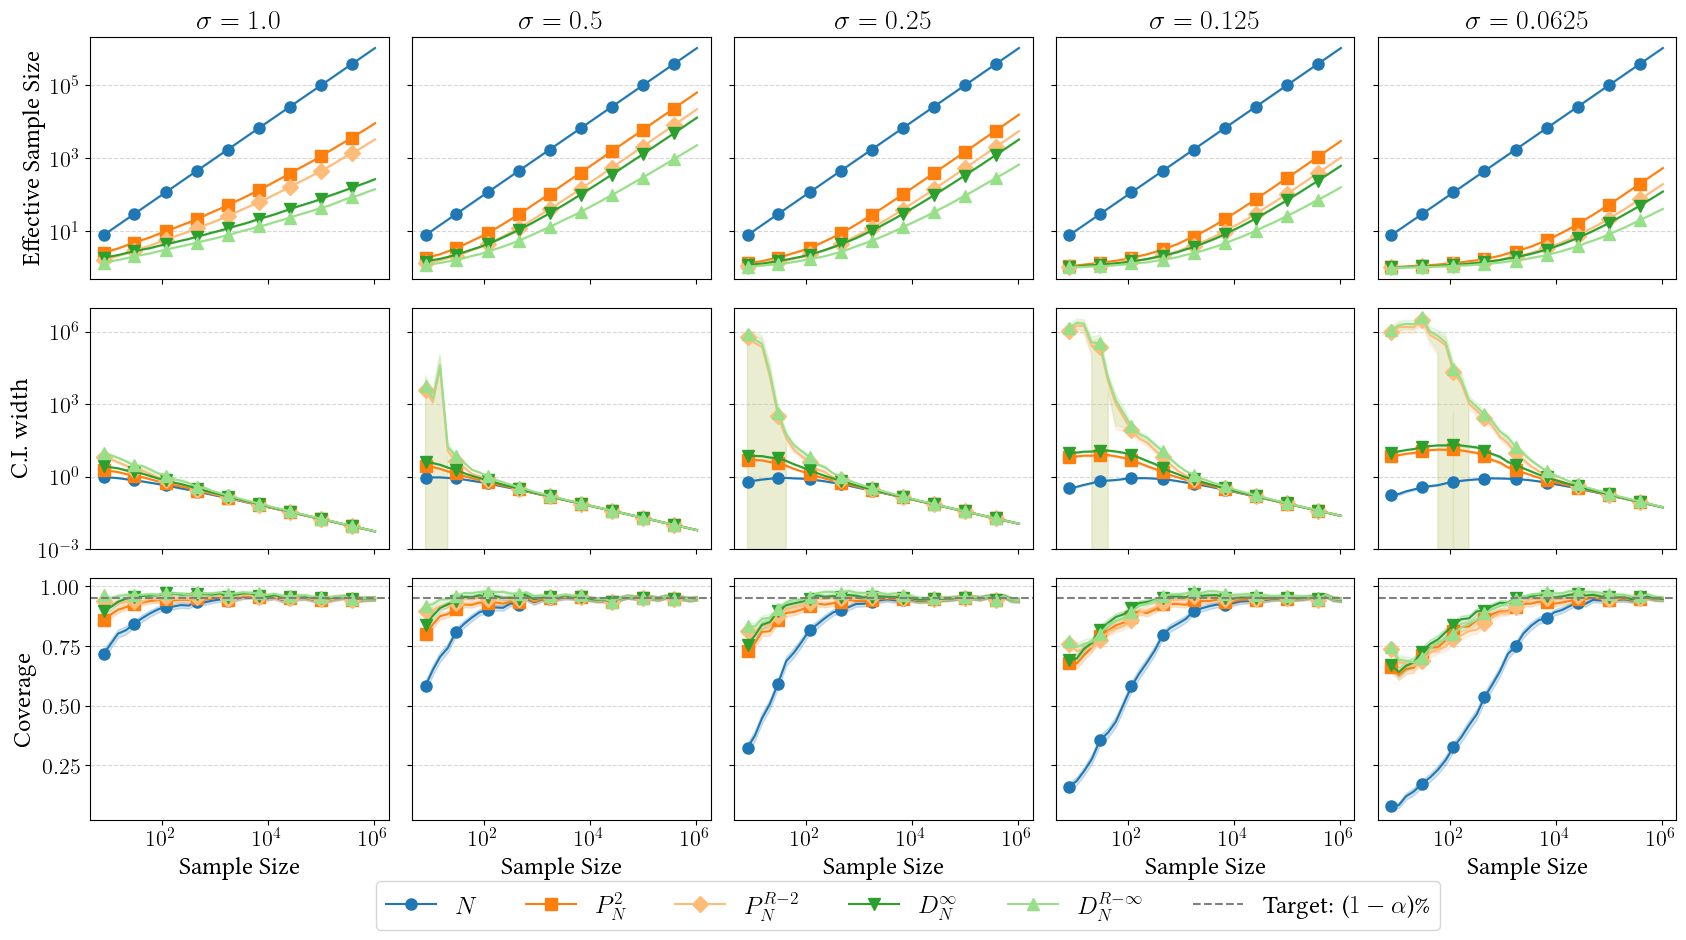

,Target,Method,Min. SS
0,1.0,$N$,891
1,1.0,$P^{2}_{N}$,84
2,1.0,$P^{R-2}_{N}$,30
3,1.0,$D^{\infty}_{N}$,21
4,1.0,$D^{R-\infty}_{N}$,8
5,0.5,$N$,636
6,0.5,$P^{2}_{N}$,636
7,0.5,$P^{R-2}_{N}$,43
8,0.5,$D^{\infty}_{N}$,43
9,0.5,$D^{R-\infty}_{N}$,15


In [7]:
result_df = plot_coverage_with_ESS(target2method2samplesize2ESS, target2method2samplesize2width, target2method2samplesize2coverage)

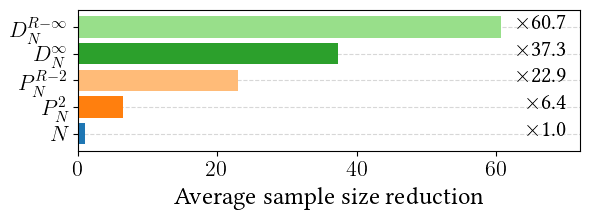

In [8]:
def plot_samplesize_decrease(result_df, aggregate_targets = True):
    
    if aggregate_targets:
        fig, ax = plt.subplots(figsize = (6.0, 2.3))
        fontsize = 20
        
        method2factors = defaultdict(list)

        for target, df in result_df.groupby('Target'):
            df['Factor'] = df['Min. SS'].values[0] / df['Min. SS']
            
            for row in df.itertuples():
                method2factors[row.Method].append(row.Factor)

                
        x = list(method2factors.keys())
        y = [np.mean(f) for f in method2factors.values()] 
        
        bars = ax.barh(x, y, color=list(name2colour.values()))

        # Iterating over the bars one-by-one
        for bar in ax.patches:
            # Using Matplotlib's annotate function and
            # passing the coordinates where the annotation shall be done
            # x-coordinate: bar.get_x() + bar.get_width() / 2
            # y-coordinate: bar.get_height()
            # free space to be left to make graph pleasing: (0, 8)
            # ha and va stand for the horizontal and vertical alignment
            ax.annotate(fr'$\times${bar.get_width():2.1f}', 
                       (70.5, 
                        bar.get_y() + bar.get_height()/5),
                        ha='right',
                        va='center',
                        size=fontsize-4,
                        xytext=(0, 8),
                        textcoords='offset points')

        ax.set_xlim(0, 72)

        ax.xaxis.set_tick_params(labelsize=fontsize-4)            
        ax.yaxis.set_tick_params(labelsize=fontsize-4)

        ax.grid(axis='y', ls='--', alpha=.5)

        #ax.set_title(fr'$\sigma={target}$', fontsize=fontsize)

        #if target == '0.25':
        ax.set_xlabel(r'Average sample size reduction', fontsize=fontsize-2)

        fig.tight_layout()
        plt.savefig('ESS_agg_samplesize_reduction.pdf', bbox_inches='tight')
        plt.show()        
    else:
        fig, axes = plt.subplots(1, len(targets), sharex=True, sharey=True, figsize = (3.4*len(targets), 2.75))
        fontsize = 20

        for ax, (target, df) in zip(axes[::-1], result_df.groupby('Target')):

            df['Factor'] = df['Min. SS'].values[0] / df['Min. SS']
            bars = ax.barh(df.Method, df.Factor, color=list(name2colour.values()))


            # Iterating over the bars one-by-one
            for bar in ax.patches:
                # Using Matplotlib's annotate function and
                # passing the coordinates where the annotation shall be done
                # x-coordinate: bar.get_x() + bar.get_width() / 2
                # y-coordinate: bar.get_height()
                # free space to be left to make graph pleasing: (0, 8)
                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(fr'$\times${bar.get_width():.1f}', 
                           (33, 
                            bar.get_y() + bar.get_height()/5),
                            ha='center',
                            va='center',
                            size=fontsize-4,
                            xytext=(0, 8),
                            textcoords='offset points')

            ax.set_xlim(0, 115)

            ax.xaxis.set_tick_params(labelsize=fontsize-4)            
            ax.yaxis.set_tick_params(labelsize=fontsize-4)

            ax.grid(axis='y', ls='--', alpha=.5)

            ax.set_title(fr'$\sigma={target}$', fontsize=fontsize)

            if target == '0.25':
                ax.set_xlabel(r'Reduction in sample size required to achieve advertised coverage level for $\alpha=0.05$', fontsize=fontsize)

        fig.tight_layout()
        plt.savefig('ESS_samplesize_reduction.pdf', bbox_inches='tight')
        plt.show()
plot_samplesize_decrease(result_df, aggregate_targets=True)